# Import necessary modules and load sql engine

In [10]:
import sqlalchemy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sqlalchemy import create_engine
from IPython.display import display_html
from datetime import datetime
from pytz import timezone

In [11]:
%load_ext sql
%sql postgresql://postgres@localhost/homedata
engine = create_engine('postgresql://postgres@localhost/homedata')

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Declare configuration variables

In [332]:
# constant variables
fc = {'work':'black', 
      'eating':'green', 
      'toilet':'purple', 
      'fitness':'red', 
      'sleep':'skyblue', 
      'personal_hygiene':'grey', 
      'shower':'blue', 
      'relax':'orange', 
      'cooking':'pink', 
      'phonecall':'teal', 
      'leave_home':'brown'}

# visualization targets and period
target_period = '72 hours'

# Fetch sensor data from TimescaleDB

In [333]:
hroom1_result = %sql SELECT * FROM sensor_data WHERE db_insert_time > now() - interval '{target_period}' AND room = 'hroom-1'
hroom2_result = %sql SELECT * FROM sensor_data WHERE db_insert_time > now() - interval '{target_period}' AND room = 'hroom-2'
act_result = %sql SELECT data_gen_time, activity, start_end FROM user_activity WHERE data_gen_time > now() - interval '{target_period}'

sensor_df1 = hroom1_result.DataFrame()
sensor_df2 = hroom2_result.DataFrame()
act_df = act_result.DataFrame()

sensor_df1.sort_values('db_insert_time', ascending = True, inplace = True)
sensor_df2.sort_values('db_insert_time', ascending = True, inplace = True)
act_df.sort_values('data_gen_time', ascending = True, inplace = True)

 * postgresql://postgres@localhost/homedata
193354 rows affected.
 * postgresql://postgres@localhost/homedata
192996 rows affected.
 * postgresql://postgres@localhost/homedata
97 rows affected.


In [334]:
r1s1 = %sql SELECT db_insert_time, (select avg(a) from unnest(sound1) as a) FROM sensor_data WHERE db_insert_time > now() - interval '{target_period}' AND room = 'hroom-1'
r1s2 = %sql SELECT db_insert_time, (select avg(a) from unnest(sound2) as a) FROM sensor_data WHERE db_insert_time > now() - interval '{target_period}' AND room = 'hroom-1'
r2s1 = %sql SELECT db_insert_time, (select avg(a) from unnest(sound1) as a) FROM sensor_data WHERE db_insert_time > now() - interval '{target_period}' AND room = 'hroom-2'
r2s2 = %sql SELECT db_insert_time, (select avg(a) from unnest(sound2) as a) FROM sensor_data WHERE db_insert_time > now() - interval '{target_period}' AND room = 'hroom-2'

r1s1_df = r1s1.DataFrame()
r1s2_df = r1s2.DataFrame()
r2s1_df = r2s1.DataFrame()
r2s2_df = r2s2.DataFrame()

r1s1_df.sort_values('db_insert_time', ascending = True, inplace = True)
r1s2_df.sort_values('db_insert_time', ascending = True, inplace = True)
r2s1_df.sort_values('db_insert_time', ascending = True, inplace = True)
r2s2_df.sort_values('db_insert_time', ascending = True, inplace = True)

 * postgresql://postgres@localhost/homedata
193355 rows affected.
 * postgresql://postgres@localhost/homedata
193355 rows affected.
 * postgresql://postgres@localhost/homedata
192997 rows affected.
 * postgresql://postgres@localhost/homedata
192997 rows affected.


# Merge data into a single dataframe in a normalized scale

## Merge Dataframe along the same timescale

### Remove microsecond digits from timestamps in DataFrame (Deprecated)

In [298]:
ms_filter = lambda x: x.replace(microsecond=0)

# initial setup with (microsecond-removed timestamp, sound_oct_avg) pairs
ts_wo_ms_11 = np.array([ms_filter(t) for t in r1s1_df['db_insert_time'].dt.to_pydatetime()])
snd11_df = pd.DataFrame(columns=['time'], data = ts_wo_ms_11)
snd11_df['snd11'] = r1s1_df['avg']

ts_wo_ms_12 = np.array([ms_filter(t) for t in r1s2_df['db_insert_time'].dt.to_pydatetime()])
snd12_df = pd.DataFrame(columns=['time'], data = ts_wo_ms_12)
snd12_df['snd12'] = r1s2_df['avg']

ts_wo_ms_21 = np.array([ms_filter(t) for t in r2s1_df['db_insert_time'].dt.to_pydatetime()])
snd21_df = pd.DataFrame(columns=['time'], data = ts_wo_ms_21)
snd21_df['snd21'] = r2s1_df['avg']

ts_wo_ms_22 = np.array([ms_filter(t) for t in r2s2_df['db_insert_time'].dt.to_pydatetime()])
snd22_df = pd.DataFrame(columns=['time'], data = ts_wo_ms_22)
snd22_df['snd22'] = r2s2_df['avg']

snd11_df.dtypes

time     datetime64[ns, psycopg2.tz.FixedOffsetTimezone...
snd11                                              float64
dtype: object

### Time-series friendly merging: pd.merge_asof()

#### Sound Sensor

In [335]:
r1s1_df.rename(columns={'avg':'snd11_roadside'}, inplace=True)
r1s2_df.rename(columns={'avg':'snd12_bed'}, inplace=True)
r2s1_df.rename(columns={'avg':'snd21_kitchen'}, inplace=True)
r2s2_df.rename(columns={'avg':'snd22_desk'}, inplace=True)

In [336]:
r1_df = pd.merge_asof(r1s1_df, r1s2_df, on='db_insert_time', tolerance=pd.Timedelta('5ms'))
r2_df = pd.merge_asof(r2s1_df, r2s2_df, on='db_insert_time', tolerance=pd.Timedelta('5ms'))

In [337]:
snd_df = pd.merge_asof(r1_df, r2_df, on='db_insert_time', tolerance=pd.Timedelta('1s'))
snd_df.rename(columns={'db_insert_time':'time'}, inplace=True)
snd_df.dropna(inplace=True)

#### Other Sensors

In [338]:
sensor_df1.drop(columns=['data_gen_time', 'room', 'sound1', 'sound2', 'airquality', 'dustconcentration'], inplace=True)
sensor_df2.drop(columns=['data_gen_time', 'room', 'sound1', 'sound2', 'airquality', 'dustconcentration'], inplace=True)

In [339]:
sensor_df1.rename(columns={'db_insert_time':'time', 'temperature':'tmp1', 'humidity':'hmd1', 'light':'light1', 'motion':'mot1'}, inplace=True)
sensor_df2.rename(columns={'db_insert_time':'time', 'temperature':'tmp2', 'humidity':'hmd2', 'light':'light2', 'motion':'mot2'}, inplace=True)

In [340]:
sensor_df = pd.merge_asof(snd_df, sensor_df1, on='time', tolerance=pd.Timedelta('1s'))
sensor_df = pd.merge_asof(sensor_df, sensor_df2, on='time', tolerance=pd.Timedelta('1s'))
sensor_df.dropna(inplace=True)

#### Addition of Weekday / Weekend

In [341]:
sensor_df

,time,snd11_roadside,snd12_bed,snd21_kitchen,snd22_desk,tmp1,hmd1,light1,mot1,tmp2,hmd2,light2,mot2
0,2020-05-09 19:03:11.089536-04:00,36.375830,34.952432,36.492363,36.130011,19.054,28.780,84.56,2.50107,19.828,27.953,65.77,2.47787
1,2020-05-09 19:03:15.792377-04:00,36.312888,34.474255,37.026425,36.431485,19.041,28.715,84.47,2.47650,19.814,27.972,65.70,2.47330
2,2020-05-09 19:03:18.057303-04:00,36.544403,34.625617,36.657970,36.191886,19.041,28.710,84.41,2.48947,19.821,27.983,65.58,2.47375
3,2020-05-09 19:03:19.185914-04:00,36.039935,34.674039,36.448336,36.421114,19.041,28.727,84.47,2.49283,19.821,27.978,65.55,2.48428
4,2020-05-09 19:03:21.444750-04:00,36.270472,35.029108,36.525647,36.330690,19.041,28.727,84.41,2.46643,19.821,27.989,65.49,2.46521
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100368,2020-05-12 19:02:50.833473-04:00,35.747589,35.488297,36.723368,36.400984,20.499,32.800,95.28,2.48550,21.074,32.352,72.51,2.46094
100369,2020-05-12 19:02:51.961877-04:00,36.241608,34.333051,36.707731,35.893691,20.492,32.806,95.25,2.49557,21.074,32.392,72.51,2.39624
100370,2020-05-12 19:02:53.107622-04:00,35.833059,35.452077,36.519905,35.971803,20.492,32.794,95.15,2.49695,21.081,32.369,72.36,2.44034
100371,2020-05-12 19:02:54.337416-04:00,35.478921,35.642836,36.634886,35.958790,20.492,32.811,95.28,2.49634,21.074,32.363,72.51,2.52365


In [342]:
weekno = sensor_df['time'][0].to_pydatetime().weekday() # if weekno <5 ? weekday : weekend
sensor_df['weekend'] = sensor_df.apply(lambda x: int(x['time'].to_pydatetime().weekday()/5), axis=1)

#### Synchronize time scale of activity dataframe to sensor dataframe

In [343]:
act_df

,data_gen_time,activity,start_end
96,2020-05-09 19:36:00-04:00,cooking,start
95,2020-05-09 19:55:00-04:00,cooking,end
94,2020-05-09 19:57:00-04:00,eating,start
93,2020-05-09 20:13:00-04:00,eating,end
92,2020-05-09 20:32:00-04:00,work,start
...,...,...,...
4,2020-05-12 16:00:00-04:00,work,start
3,2020-05-12 16:56:00-04:00,relax,start
2,2020-05-12 16:56:00-04:00,work,end
1,2020-05-12 17:20:00-04:00,work,start


In [344]:
# drop activity rows earlier than the head of sensor_df

# drop activity rows later than the tail of sensor_df


/Users/heesuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


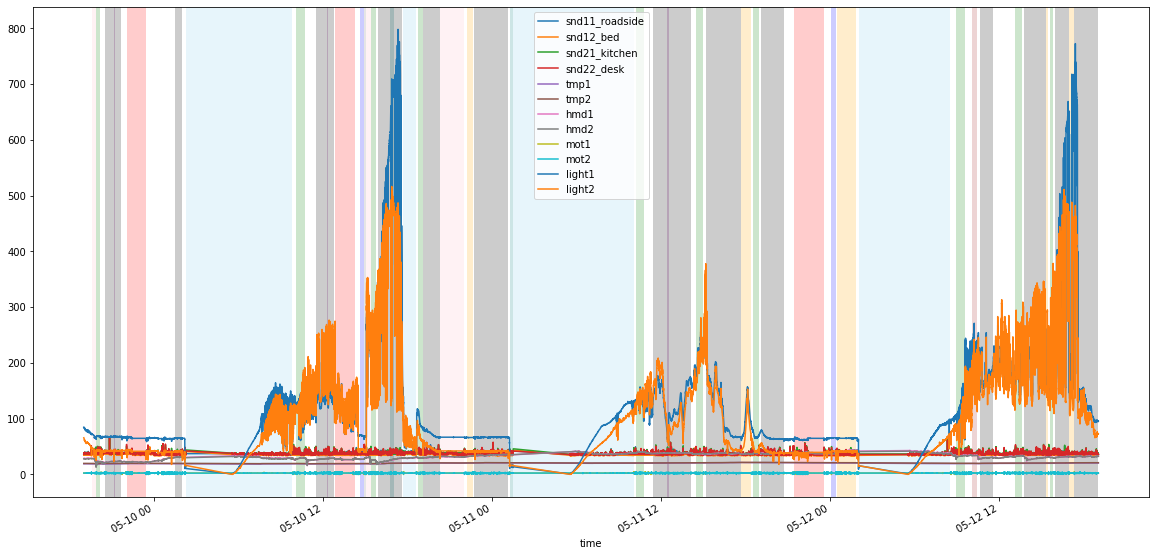

In [345]:
# initialize plotting
ax = plt.gca()

# add sensor values to the target plot
sensor_df.plot(kind='line', x='time', y='snd11_roadside', ax=ax)
sensor_df.plot(kind='line', x='time', y='snd12_bed', ax=ax)
sensor_df.plot(kind='line', x='time', y='snd21_kitchen', ax=ax)
sensor_df.plot(kind='line', x='time', y='snd22_desk', ax=ax)
sensor_df.plot(kind='line', x='time', y='tmp1', ax=ax)
sensor_df.plot(kind='line', x='time', y='tmp2', ax=ax)
sensor_df.plot(kind='line', x='time', y='hmd1', ax=ax)
sensor_df.plot(kind='line', x='time', y='hmd2', ax=ax)
sensor_df.plot(kind='line', x='time', y='mot1', ax=ax)
sensor_df.plot(kind='line', x='time', y='mot2', ax=ax)
sensor_df.plot(kind='line', x='time', y='light1', ax=ax)
sensor_df.plot(kind='line', x='time', y='light2', ax=ax)

# add activity periods to the target plot
act_stack = {} # stack implemented as a dict which stores unclosed/unfinished activities to be visualized

start_T = ''
end_T = ''

log = {'err':'', 'debug':''}

# converts numpy.datetime64 to datetime.
# datetime is compatible with pandas.timestamp with timezone.
def convT(T_dt64):
    T_ts = (T_dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.fromtimestamp(T_ts).astimezone(timezone('US/Eastern'))

# visualize starts here
for index, row in act_df.iterrows():    
    act = row['activity']
    
    if row['start_end'] == 'start':
        if act in act_stack.keys():
            log['err'] += 'The given activity is already in the activity stack.' # error message
        else:
            act_stack[act] = {}
            log['debug'] += '{} is added to act_stack.\n'.format(act)
            #print('{} is added to act_stack.'.format(act))

            start_T = row['data_gen_time']

            if index == act_df.size-1: # if this is the last row
                end_T = convT(sensor_df.tail(1)['time'].values[0])
                log['debug'] += "act={}, start_T={}, end_T={}, color={}\n".format(act, str(start_T), str(end_T), fc[act])
                ax.axvspan(start_T, end_T, label = act, facecolor=fc[act], alpha=0.2)
                act_stack.pop(act)
                log['debug'] += '[1] act_stack.pop({})\n'.format(act)
            else:
                act_stack[act]['start_T'] = start_T
    else: # row['start_end'] == 'end'
        end_T = row['data_gen_time']
        
        if act in act_stack.keys():
            act_stack[act]['end_T'] = end_T
            log['debug'] += "act={}, start_T={}, end_T={}, color={}\n".format(act, str(act_stack[act]['start_T']), str(act_stack[act]['end_T']), fc[act])
            ax.axvspan(act_stack[act]['start_T'], act_stack[act]['end_T'], label = act, facecolor=fc[act], alpha=0.2)
            act_stack.pop(act)
            log['debug'] += '[2] act_stack.pop({})\n'.format(act)
        else:
            if start_T == '':
                start_T = convT(sensor_df.head(1)['time'].values[0])
            
            log['debug'] += "act={}, start_T={}, end_T={}, color={}\n".format(act, str(start_T), str(end_T), fc[act])
            ax.axvspan(start_T, end_T, label = act, facecolor=fc[act], alpha=0.2)
            
if len(act_stack.keys()) != 0:
    log['debug'] += "len(act_stack.keys()) = {}\n".format(len(act_stack.keys()))
    log['debug'] += "act_stack = {}\n".format(str(act_stack))
    
    for act in act_stack.keys():
        end_T = convT(sensor_df.tail(1)['time'].values[0])
        ax.axvspan(start_T, end_T, label = act, facecolor=fc[act], alpha=0.2)


# plot
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

## Normalize Dataframe values along all columns
To facilitate any machine learning training phases, the sensor values will be normalized into a range [0, 1], considering the possible data range of each sensor.

#### Valid data range of each used sensors:
* Sound Phidget: 34~102 dB (SPL)
* Humidity/Temperature Phidget: -30 ~ 80C, 10 ~ 95%
* Precision Light Phidget: 1000 lux
* Motion Phidget: Not found but maybe 0~10

#### How to normalize each sensor:
* Sound Phidget: (x-30)/70
* Humidity: x/100
* Temperature: (x+20)/100, assuming that temp. never goes down to -20C
* Light: x/1000
* Motion: x/10

In [346]:
sensor_df

,time,snd11_roadside,snd12_bed,snd21_kitchen,snd22_desk,tmp1,hmd1,light1,mot1,tmp2,hmd2,light2,mot2,weekend
0,2020-05-09 19:03:11.089536-04:00,36.375830,34.952432,36.492363,36.130011,19.054,28.780,84.56,2.50107,19.828,27.953,65.77,2.47787,1
1,2020-05-09 19:03:15.792377-04:00,36.312888,34.474255,37.026425,36.431485,19.041,28.715,84.47,2.47650,19.814,27.972,65.70,2.47330,1
2,2020-05-09 19:03:18.057303-04:00,36.544403,34.625617,36.657970,36.191886,19.041,28.710,84.41,2.48947,19.821,27.983,65.58,2.47375,1
3,2020-05-09 19:03:19.185914-04:00,36.039935,34.674039,36.448336,36.421114,19.041,28.727,84.47,2.49283,19.821,27.978,65.55,2.48428,1
4,2020-05-09 19:03:21.444750-04:00,36.270472,35.029108,36.525647,36.330690,19.041,28.727,84.41,2.46643,19.821,27.989,65.49,2.46521,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100368,2020-05-12 19:02:50.833473-04:00,35.747589,35.488297,36.723368,36.400984,20.499,32.800,95.28,2.48550,21.074,32.352,72.51,2.46094,0
100369,2020-05-12 19:02:51.961877-04:00,36.241608,34.333051,36.707731,35.893691,20.492,32.806,95.25,2.49557,21.074,32.392,72.51,2.39624,0
100370,2020-05-12 19:02:53.107622-04:00,35.833059,35.452077,36.519905,35.971803,20.492,32.794,95.15,2.49695,21.081,32.369,72.36,2.44034,0
100371,2020-05-12 19:02:54.337416-04:00,35.478921,35.642836,36.634886,35.958790,20.492,32.811,95.28,2.49634,21.074,32.363,72.51,2.52365,0


In [347]:
sensor_df['snd11_roadside'] = sensor_df.apply(lambda x: (x['snd11_roadside']-30)/70, axis=1)
sensor_df['snd12_bed'] = sensor_df.apply(lambda x: (x['snd12_bed']-30)/70, axis=1)
sensor_df['snd21_kitchen'] = sensor_df.apply(lambda x: (x['snd21_kitchen']-30)/70, axis=1)
sensor_df['snd22_desk'] = sensor_df.apply(lambda x: (x['snd22_desk']-30)/70, axis=1)
sensor_df['tmp1'] = sensor_df.apply(lambda x: (x['tmp1']+20)/100, axis=1)
sensor_df['tmp2'] = sensor_df.apply(lambda x: (x['tmp2']+20)/100, axis=1)
sensor_df['hmd1'] = sensor_df.apply(lambda x: x['hmd1']/100, axis=1)
sensor_df['hmd2'] = sensor_df.apply(lambda x: x['hmd2']/100, axis=1)
sensor_df['light1'] = sensor_df.apply(lambda x: x['light1']/1000, axis=1)
sensor_df['light2'] = sensor_df.apply(lambda x: x['light2']/1000, axis=1)
sensor_df['mot1'] = sensor_df.apply(lambda x: x['mot1']/10, axis=1)
sensor_df['mot2'] = sensor_df.apply(lambda x: x['mot2']/10, axis=1)
sensor_df

,time,snd11_roadside,snd12_bed,snd21_kitchen,snd22_desk,tmp1,hmd1,light1,mot1,tmp2,hmd2,light2,mot2,weekend
0,2020-05-09 19:03:11.089536-04:00,0.091083,0.070749,0.092748,0.087572,0.39054,0.28780,0.08456,0.250107,0.39828,0.27953,0.06577,0.247787,1
1,2020-05-09 19:03:15.792377-04:00,0.090184,0.063918,0.100378,0.091878,0.39041,0.28715,0.08447,0.247650,0.39814,0.27972,0.06570,0.247330,1
2,2020-05-09 19:03:18.057303-04:00,0.093491,0.066080,0.095114,0.088456,0.39041,0.28710,0.08441,0.248947,0.39821,0.27983,0.06558,0.247375,1
3,2020-05-09 19:03:19.185914-04:00,0.086285,0.066772,0.092119,0.091730,0.39041,0.28727,0.08447,0.249283,0.39821,0.27978,0.06555,0.248428,1
4,2020-05-09 19:03:21.444750-04:00,0.089578,0.071844,0.093224,0.090438,0.39041,0.28727,0.08441,0.246643,0.39821,0.27989,0.06549,0.246521,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100368,2020-05-12 19:02:50.833473-04:00,0.082108,0.078404,0.096048,0.091443,0.40499,0.32800,0.09528,0.248550,0.41074,0.32352,0.07251,0.246094,0
100369,2020-05-12 19:02:51.961877-04:00,0.089166,0.061901,0.095825,0.084196,0.40492,0.32806,0.09525,0.249557,0.41074,0.32392,0.07251,0.239624,0
100370,2020-05-12 19:02:53.107622-04:00,0.083329,0.077887,0.093141,0.085311,0.40492,0.32794,0.09515,0.249695,0.41081,0.32369,0.07236,0.244034,0
100371,2020-05-12 19:02:54.337416-04:00,0.078270,0.080612,0.094784,0.085126,0.40492,0.32811,0.09528,0.249634,0.41074,0.32363,0.07251,0.252365,0


# Visualize the MTS data with activity data labels

/Users/heesuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


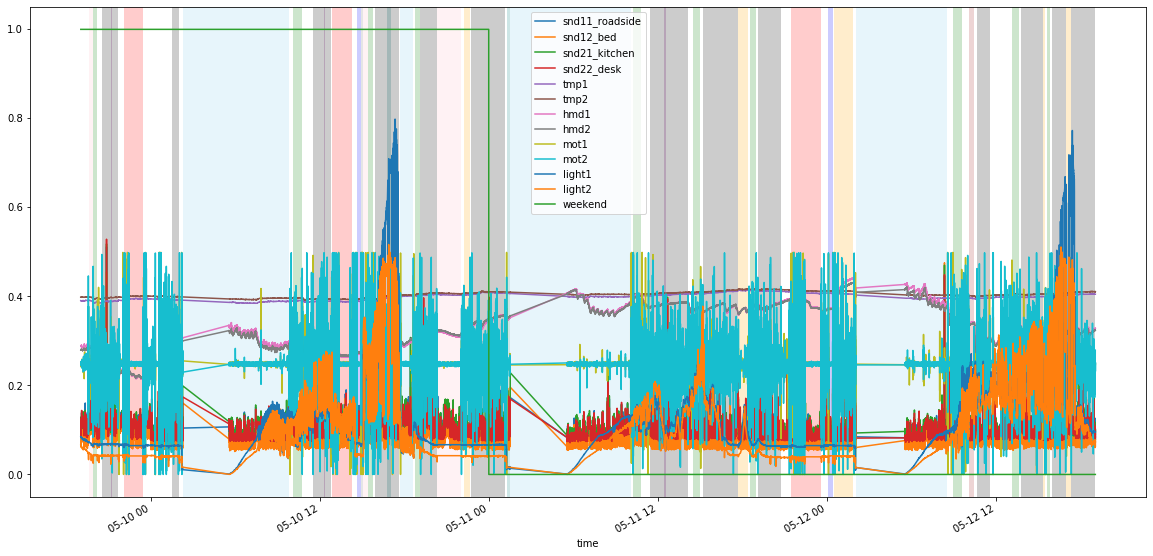

In [348]:
# initialize plotting
ax = plt.gca()

# add sensor values to the target plot
sensor_df.plot(kind='line', x='time', y='snd11_roadside', ax=ax)
sensor_df.plot(kind='line', x='time', y='snd12_bed', ax=ax)
sensor_df.plot(kind='line', x='time', y='snd21_kitchen', ax=ax)
sensor_df.plot(kind='line', x='time', y='snd22_desk', ax=ax)
sensor_df.plot(kind='line', x='time', y='tmp1', ax=ax)
sensor_df.plot(kind='line', x='time', y='tmp2', ax=ax)
sensor_df.plot(kind='line', x='time', y='hmd1', ax=ax)
sensor_df.plot(kind='line', x='time', y='hmd2', ax=ax)
sensor_df.plot(kind='line', x='time', y='mot1', ax=ax)
sensor_df.plot(kind='line', x='time', y='mot2', ax=ax)
sensor_df.plot(kind='line', x='time', y='light1', ax=ax)
sensor_df.plot(kind='line', x='time', y='light2', ax=ax)
sensor_df.plot(kind='line', x='time', y='weekend', ax=ax)

# add activity periods to the target plot
act_stack = {} # stack implemented as a dict which stores unclosed/unfinished activities to be visualized

start_T = ''
end_T = ''

log = {'err':'', 'debug':''}

# converts numpy.datetime64 to datetime.
# datetime is compatible with pandas.timestamp with timezone.
def convT(T_dt64):
    T_ts = (T_dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.fromtimestamp(T_ts).astimezone(timezone('US/Eastern'))

# visualize starts here
for index, row in act_df.iterrows():    
    act = row['activity']
    
    if row['start_end'] == 'start':
        if act in act_stack.keys():
            log['err'] += 'The given activity is already in the activity stack.' # error message
        else:
            act_stack[act] = {}
            log['debug'] += '{} is added to act_stack.\n'.format(act)
            #print('{} is added to act_stack.'.format(act))

            start_T = row['data_gen_time']

            if index == act_df.size-1: # if this is the last row
                end_T = convT(sensor_df.tail(1)['time'].values[0])
                log['debug'] += "act={}, start_T={}, end_T={}, color={}\n".format(act, str(start_T), str(end_T), fc[act])
                ax.axvspan(start_T, end_T, label = act, facecolor=fc[act], alpha=0.2)
                act_stack.pop(act)
                log['debug'] += '[1] act_stack.pop({})\n'.format(act)
            else:
                act_stack[act]['start_T'] = start_T
    else: # row['start_end'] == 'end'
        end_T = row['data_gen_time']
        
        if act in act_stack.keys():
            act_stack[act]['end_T'] = end_T
            log['debug'] += "act={}, start_T={}, end_T={}, color={}\n".format(act, str(act_stack[act]['start_T']), str(act_stack[act]['end_T']), fc[act])
            ax.axvspan(act_stack[act]['start_T'], act_stack[act]['end_T'], label = act, facecolor=fc[act], alpha=0.2)
            act_stack.pop(act)
            log['debug'] += '[2] act_stack.pop({})\n'.format(act)
        else:
            if start_T == '':
                start_T = convT(sensor_df.head(1)['time'].values[0])
            
            log['debug'] += "act={}, start_T={}, end_T={}, color={}\n".format(act, str(start_T), str(end_T), fc[act])
            ax.axvspan(start_T, end_T, label = act, facecolor=fc[act], alpha=0.2)
            
if len(act_stack.keys()) != 0:
    log['debug'] += "len(act_stack.keys()) = {}\n".format(len(act_stack.keys()))
    log['debug'] += "act_stack = {}\n".format(str(act_stack))
    
    for act in act_stack.keys():
        end_T = convT(sensor_df.tail(1)['time'].values[0])
        ax.axvspan(start_T, end_T, label = act, facecolor=fc[act], alpha=0.2)


# plot
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

### Color Mapping to Activities
* Work = Black
* Eating = Green
* Toilet = Purple
* Fitness = Red
* Sleep = Skyblue
* Personal_hygiene = Grey
* Shower = Blue
* Relax = Orange
* Cooking = Pink
* Phonecall = Teal

# Construct (X,Y) pairs out of the dataframe for DNN models

## Transformation from dataframe to (X,Y) pairs

## Split the dataset for training and validation sets